In [8]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
#choses backend pytorch here if it hasnt already

In [15]:
#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m

h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants
T = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 60
y0 = mols0/sum(mols0)
print(y0)
Ctot = P/(8.3144598 * 10**-5 * T)

u0 = sum(sccm0) * 273 / T * P / 1 / 60 #cm^3/sec
A = np.pi * ((R_outer*100)**2-(R_inner*100)**2) #cm^2 MIGHT HAVE TO ADJUST THE AREA CALC A BIT
v0 = u0 / A / 100 #m/sec

#rate equation constants
Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

I = 9 #curent in Amps
F = 96485 #faradays constant
Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
Keqwgs = np.exp(4400/T - 4.036)

#discritization space
geom = dde.geometry.Interval(0, L)

def odes(x, y):
    Cch4, Ch2o, Cco, Cco2, Ch2, Car = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4], y[:, 4:5], y[:, 5:6]
    #JUST ADD TEMP AS A VARIABLE AND YOU ADD THE EQUATION AND CONSTANT IN Y
    
    v = v0*(3*y0[1] - 2*Cch4)/y0[1] # v0*(1+2X)

    rsmr = 2/R_outer*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(Cch4*Ch2o-(P**2)*Cco*(Ch2**3)/Keqsmr)/Ctot
    rwgs = 2/R_outer*Ku*Asmr*np.exp(-Eawgs*1000/Rgas/T)*(Ch2o*Cco2-Cco*Ch2/Keqwgs)/Ctot
    rh2r = I/(2*F*L)/Ctot #have not confirmed if this is correct

    #for the jacobian, the i is the component, and then j (ignored here) is the axis (so like are we moving in x-direction or time)
    ch4 = dde.grad.jacobian(y, x, i=0) - (-rsmr)/v
    h2o = dde.grad.jacobian(y, x, i=1) - (-rsmr - rwgs)/v
    co = dde.grad.jacobian(y, x, i=2) - (rsmr - rwgs)/v
    co2 = dde.grad.jacobian(y, x, i=3) - (rwgs)/v
    h2 = dde.grad.jacobian(y, x, i=4) - (3*rsmr + rwgs + h2Removal*rh2r)/v
    ar = dde.grad.jacobian(y, x, i=5)
    return [ch4, h2o, co, co2, h2, ar]

def bcs(x, on_initial):
    return on_initial and dde.utils.isclose(x[0],0)
    #here t[0] has to be 0 because it is the x-direction axis ("j = 0")

bc_ch4 = dde.DirichletBC(geom, lambda x: y0[0], bcs, component=0)
bc_h2o = dde.DirichletBC(geom, lambda x: y0[1], bcs, component=1)
bc_co = dde.DirichletBC(geom, lambda x: y0[2], bcs, component=2)
bc_co2 = dde.DirichletBC(geom, lambda x: y0[3], bcs, component=3)
bc_h2 = dde.DirichletBC(geom, lambda x: y0[4], bcs, component=4)
bc_ar = dde.DirichletBC(geom, lambda x: y0[5], bcs, component=5)


[0.20291311 0.60873933 0.         0.         0.12556504 0.06278252]


Compiling model...
'compile' took 0.003690 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [1.45e-01, 5.01e+03, 5.08e+03, 4.91e+03, 5.02e+03, 1.45e-02, 4.12e-02, 3.71e-01, 0.00e+00, 0.00e+00, 1.58e-02, 3.94e-03]    [1.45e-01, 4.77e+03, 4.84e+03, 4.67e+03, 4.78e+03, 1.45e-02, 4.12e-02, 3.71e-01, 0.00e+00, 0.00e+00, 1.58e-02, 3.94e-03]    []  
1000      [5.85e-04, 7.03e-02, 8.39e-02, 4.87e-02, 5.28e-02, 1.79e-08, 6.52e-02, 3.30e-01, 7.52e-05, 3.48e-10, 1.59e-02, 1.59e-12]    [5.79e-04, 7.03e-02, 6.65e-02, 3.92e-02, 4.88e-02, 1.63e-08, 6.52e-02, 3.30e-01, 7.52e-05, 3.48e-10, 1.59e-02, 1.59e-12]    []  
2000      [6.25e-04, 2.11e-02, 3.61e-02, 1.34e-03, 6.54e-03, 1.79e-08, 6.52e-02, 3.30e-01, 7.40e-05, 1.27e-10, 1.58e-02, 8.88e-16]    [6.19

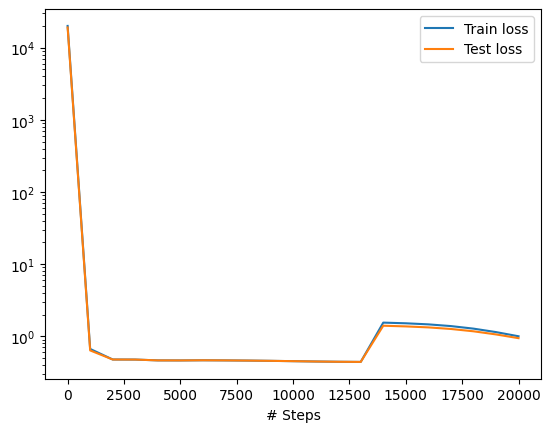

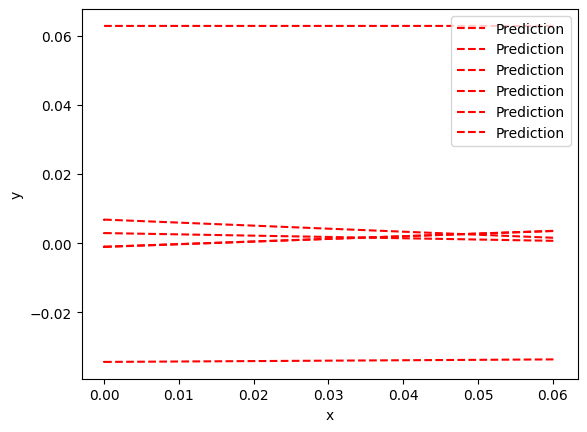

In [17]:

data = dde.data.PDE(geom, 
    odes, 
    [bc_ch4, bc_h2o, bc_co, bc_co2, bc_h2, bc_ar],
    num_domain=400, 
    num_boundary=20, 
    num_test=100)

net = dde.nn.FNN([1] + [50] * 6 + [6], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)